# Kickstarter Projects Exploration
## by Gihan Mohamed Ahmed Ali

## Preliminary Wrangling

> Kickstarter is a funding platform for creative projects. ... Every project creator sets their project's funding goal and deadline. If people like the project, they can pledge money to make it happen. If the project succeeds in reaching its funding goal, all backers' credit cards are charged when time expires. The current dataset is collected from Kickstarter websites and contains characeristics of 378,661 kickstarter project.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print statistics
kickstarter = pd.read_csv("C:/Users/KIMOSTORE/ks-projects-2.csv")

In [3]:
# high-level overview of data shape and composition
print(kickstarter.shape)
print(kickstarter.dtypes)
print(kickstarter.head(10))

(378661, 15)
ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object
           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   
5  1000014025                               Monarch Espresso Bar   
6  1000023410  Support Solar Roasted Coffee & Green Energy!  ...   
7  100003

In [4]:
# descriptive statistics for numeric variables
print(kickstarter.describe())
kickstarter.columns

                 ID          goal       pledged        backers   usd pledged  \
count  3.786610e+05  3.786610e+05  3.786610e+05  378661.000000  3.748640e+05   
mean   1.074731e+09  4.908079e+04  9.682979e+03     105.617476  7.036729e+03   
std    6.190862e+08  1.183391e+06  9.563601e+04     907.185035  7.863975e+04   
min    5.971000e+03  1.000000e-02  0.000000e+00       0.000000  0.000000e+00   
25%    5.382635e+08  2.000000e+03  3.000000e+01       2.000000  1.698000e+01   
50%    1.075276e+09  5.200000e+03  6.200000e+02      12.000000  3.947200e+02   
75%    1.610149e+09  1.600000e+04  4.076000e+03      56.000000  3.034090e+03   
max    2.147476e+09  1.000000e+08  2.033899e+07  219382.000000  2.033899e+07   

       usd_pledged_real  usd_goal_real  
count      3.786610e+05   3.786610e+05  
mean       9.058924e+03   4.545440e+04  
std        9.097334e+04   1.152950e+06  
min        0.000000e+00   1.000000e-02  
25%        3.100000e+01   2.000000e+03  
50%        6.243300e+02   5.50000

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [5]:
# dropping columns that won't be analyzed
kickstarter = kickstarter.drop(['ID', 'name', 'goal', 'pledged', 'usd pledged'], axis=1)

In [6]:
#removing outliers
Q1 = kickstarter.quantile(0.25)
Q3 = kickstarter.quantile(0.75)
IQR = Q3 - Q1

kickstarter = kickstarter[~((kickstarter < (Q1 - 1.5 * IQR)) |(kickstarter > (Q3 + 1.5 * IQR))).any(axis=1)]

In [7]:
# convert 'launched' and 'deadline' features into date types and extracting month and year to new columns
kickstarter['launched'] = pd.to_datetime(kickstarter['launched'])
kickstarter['deadline'] = pd.to_datetime(kickstarter['deadline'])
kickstarter['laun_year'] = kickstarter.launched.dt.year

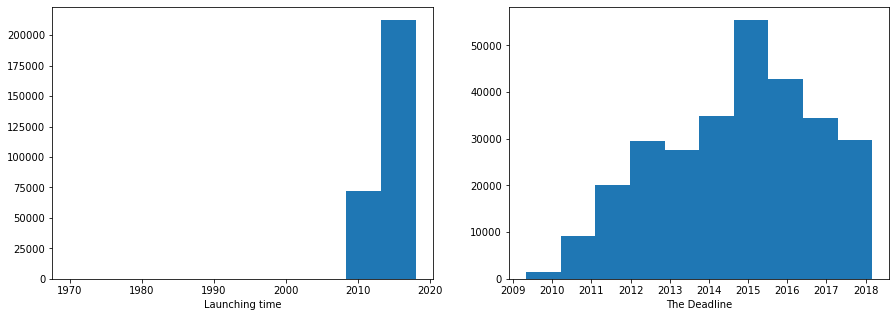

In [8]:

# Visualizing the distribution of Launching time and The Deadline 
plt.figure(figsize = [15, 5])

# left histogram: Launching time distribution
plt.subplot(1, 2, 1)
plt.hist(kickstarter['launched']);
plt.xlabel('Launching time');

# right histogram: The Deadline distribution
plt.subplot(1, 2, 2)
plt.hist(kickstarter['deadline']);
plt.xlabel('The Deadline');

In [9]:
# filtering out observations with launch date before 2009
((kickstarter['launched'])< '2009-01-01').index
kickstarter = kickstarter[(kickstarter['launched'].dt.year > 2008)]
kickstarter.shape

(284826, 11)

In [10]:
# verifying the existence of null values
kickstarter.isnull().sum()

category            0
main_category       0
currency            0
deadline            0
launched            0
state               0
backers             0
country             0
usd_pledged_real    0
usd_goal_real       0
laun_year           0
dtype: int64

### What is the structure of your dataset?

There are 284826 kickstarter project in the dataset after cleaning with 11 features ( 'category', 'main_category', 'currency', 'deadline', 'launched', 'state', 'backers', 'country','usd pledged', 'usd_pledged_real', 'usd_goal_real','laun_year'). Some variables are numeric in nature and others are string, but the variables 'deadline', 'launched', and 'laun_year' are datetime.


### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out what features are best for predicting  whether the projects will succeed.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that backers will have the strongest effect on project success: the higher the number of backers, the higher the probability of success. I also think that the other features: 'usd_pledged_real', 'usd_goal_real','category', and 'main_category', will have effects on project success.

## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: state of the project.

In [11]:
kickstarter["state"].value_counts()

failed        164781
successful     83431
canceled       29492
undefined       3557
live            2194
suspended       1371
Name: state, dtype: int64

In [12]:
# filtering out the project states that we are not concerned in predicting, namely; undefined, live, suspended
kickstarter = kickstarter[kickstarter["state"].isin(["canceled","failed", "successful"])]

In [13]:
# integrating canceled with failed state
kickstarter.loc[kickstarter.state.isin(['suspended', 'canceled']), 'state'] = 'failed'

In [14]:
kickstarter.state.value_counts()

failed        194273
successful     83431
Name: state, dtype: int64

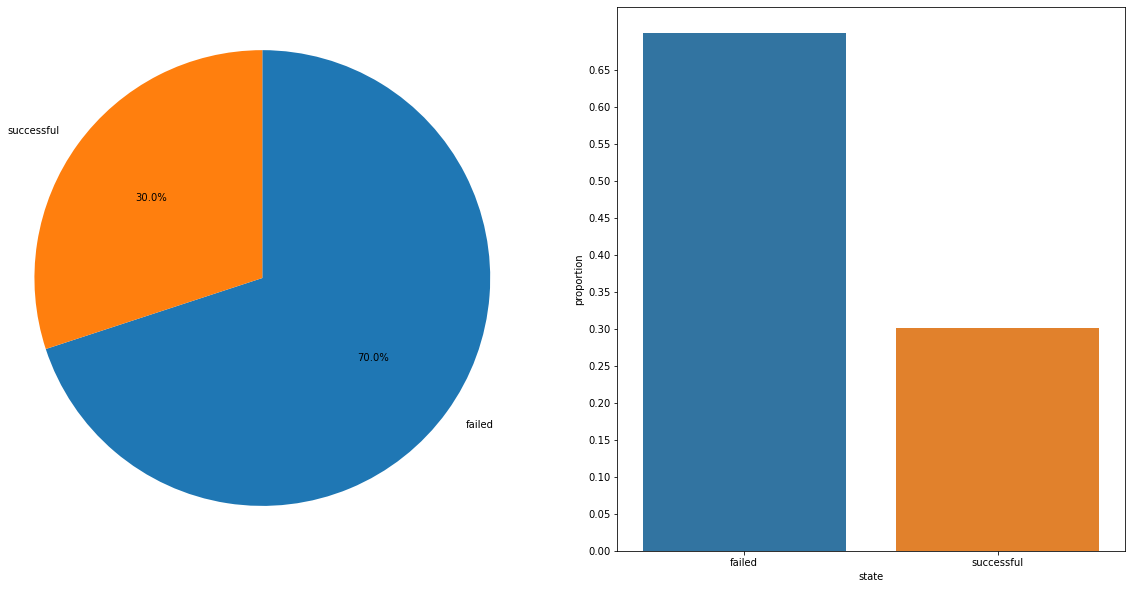

In [15]:
# plotting the relative proportion of different states
plt.figure(figsize = [20, 10]) 

plt.subplot(1, 2, 1) 

sorted_counts = kickstarter['state'].value_counts() 
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90,
        counterclock = False, autopct='%1.1f%%');
plt.axis('square');

plt.subplot(1, 2, 2)
# get proportion taken by most common group for derivation
# of tick marks
n_points = kickstarter.shape[0]
max_count = kickstarter['state'].value_counts().max()
max_prop = max_count / n_points

# generate tick mark locations and names
tick_props = np.arange(0, max_prop, 0.05)
tick_names = ['{:0.2f}'.format(v) for v in tick_props]

# create the plot
base_color = sb.color_palette()[0]
cat_order = kickstarter['state'].value_counts().index
sb.countplot(data = kickstarter, x = 'state',  order = cat_order);
plt.yticks(tick_props * n_points, tick_names);
plt.ylabel('proportion');

As can be seen from the plots above, the majority of projects have failed or canceled (around 60%, and 10% repectively) while only 30% have succeeded.

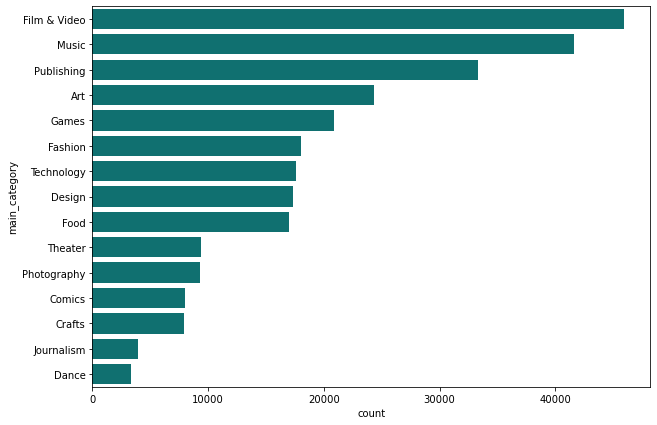

In [16]:
# visualizing the frequency of main categories 
plt.figure(figsize = [10, 7]) 
cat_order = kickstarter['main_category'].value_counts().index
sb.countplot(data = kickstarter, y = 'main_category', order = cat_order, color ='teal');

It can be seen that some categories are more popular than others with Film & Video, Music & Publishing being the top categories.

In [17]:
# Further analysis of the top 3 main categories
film = kickstarter[kickstarter['main_category']=='Film & Video']
Music = kickstarter[kickstarter['main_category']=='Music']
Publishing = kickstarter[kickstarter['main_category']=='Publishing']

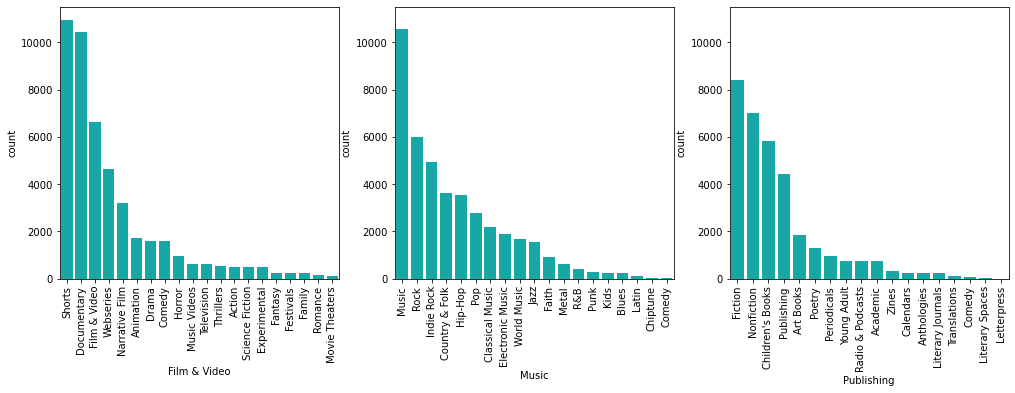

In [18]:
## Visualizing sub-categories within each of the top three main categories
plt.figure(figsize = [17, 5]) 

plt.subplot(1, 3, 1)
order1 = film['category'].value_counts().index
ax1 = sb.countplot(data = film, x = 'category', order = order1, color ='c')
plt.xticks(rotation=90) 
plt.xlabel('Film & Video');

plt.subplot(1, 3, 2)
order2 = Music['category'].value_counts().index
sb.countplot(data = Music, x = 'category', order = order2, color ='c')
plt.xticks(rotation=90)
plt.ylim(ax1.get_ylim())
plt.xlabel('Music');

plt.subplot(1, 3, 3)
order3 = Publishing['category'].value_counts().index
sb.countplot(data = Publishing, x = 'category', order = order3, color ='c')
plt.xticks(rotation=90) 
plt.ylim(ax1.get_ylim())
plt.xlabel('Publishing');

It can be seen that in each main category of the top 3 categories, some sub categories are more  popular than others. Specifically, in film & video, shorts & Documentary are more frequent than others. In Music category, Music sub-cateory is the most frequent. Finally, in Publishing, Fiction and Nonfiction are more frequent subcategories.

C:\Users\KIMOSTORE\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


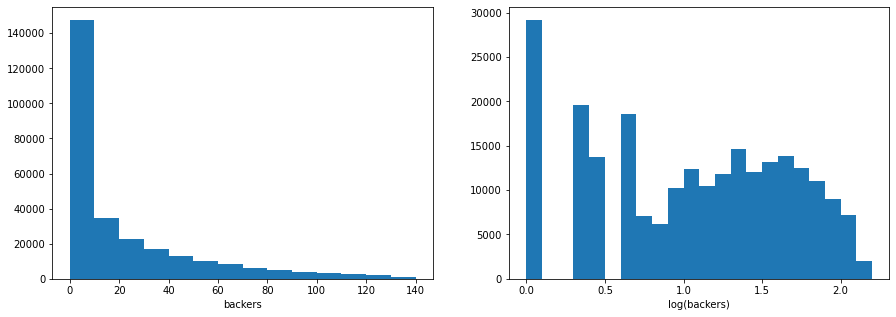

In [19]:
## now we will look at the distribution of backers 
plt.figure(figsize = [15, 5])

# left histogram: data plotted in natural units
plt.subplot(1, 2, 1)
bin_edges = np.arange(0, kickstarter['backers'].max()+10, 10)
plt.hist(kickstarter['backers'], bins = bin_edges)
plt.xlabel('backers')

# right histogram: data plotted after direct log transformation
plt.subplot(1, 2, 2)
log_data = np.log10(kickstarter['backers']) # direct data transform
log_bin_edges = np.arange(0, log_data.max()+0.1, 0.1)
plt.hist(log_data, bins = log_bin_edges)
plt.xlabel('log(backers)');

As shown above the distribution of backers is very right skewed, while its distribution after log transformation is approximately normal with some outliers.

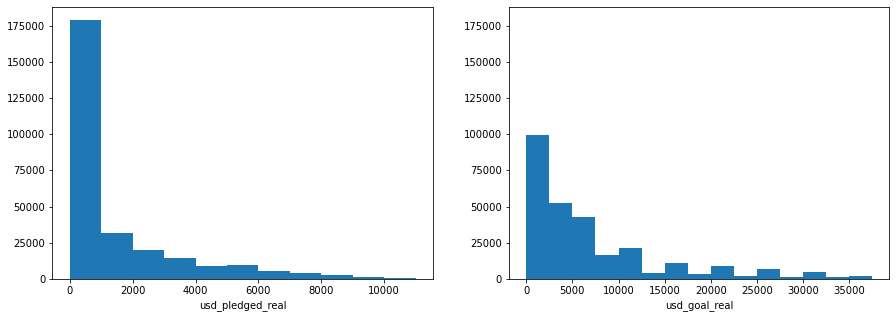

In [20]:
# Visualizing the distribution of the goal and pledge amounts in USD
plt.figure(figsize = [15, 5])

# left histogram: usd_goal distribution
plt.subplot(1, 2, 1)
bin_edges = np.arange(0, kickstarter['usd_pledged_real'].max()+1000, 1000)
plt.hist(kickstarter['usd_pledged_real'], bins = bin_edges)
plt.xlabel('usd_pledged_real');
axes = plt.gca()
# right histogram: usd_pledged distribution
plt.subplot(1, 2, 2)
bin_edges = np.arange(0, kickstarter['usd_goal_real'].max()+2500, 2500)
plt.hist(kickstarter['usd_goal_real'], bins = bin_edges)
plt.xlabel('usd_goal_real')
plt.ylim(axes.get_ylim());

The distribution of both the pledged amount and the goal amount are right skewed with the range of goal is much higher than that of the amount actually pledged.

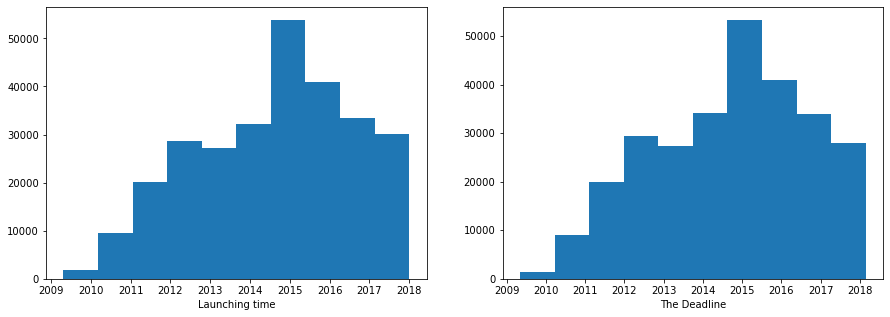

In [21]:
# Visualizing the distribution of Launching time and The Deadline where both distributions are approximately normal
plt.figure(figsize = [15, 5])

# left histogram: Launching time distribution
plt.subplot(1, 2, 1)
plt.hist(kickstarter['launched']);
plt.xlabel('Launching time');

# right histogram: The Deadline distribution
plt.subplot(1, 2, 2)
plt.hist(kickstarter['deadline']);
plt.xlabel('The Deadline');

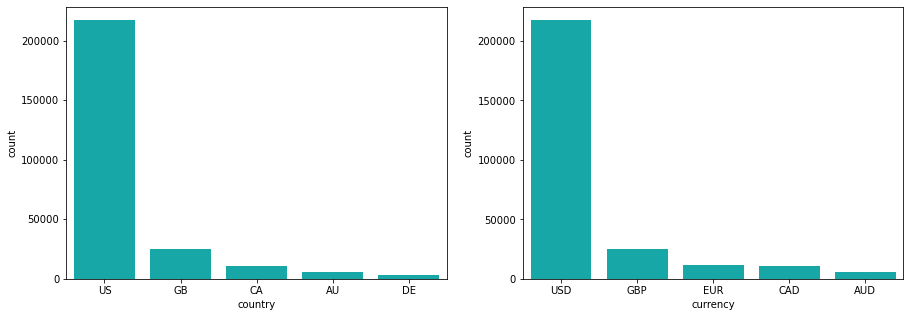

In [22]:
# Visualizing the frequency of the top 5 countries and currencies launching kickstarter projects
plt.figure(figsize = [15, 5])

# left bar: the countries frequencies
plt.subplot(1, 2, 1)
order5 = kickstarter['country'].value_counts().index
sb.countplot(data = kickstarter, x = 'country', order = order5, color ='c')
plt.xlim(-0.5, 4.5)

# right bar: The curriencies frequencies
plt.subplot(1, 2, 2)
order5 = kickstarter['currency'].value_counts().index
sb.countplot(data = kickstarter, x = 'currency', order = order5, color ='c');
plt.xlim(-0.5, 4.5);

The above visual shows that the more than 200,000 kisckstarter projects are dominant in the USA in USD currency.
While other countries do not exceed 50000 projects.

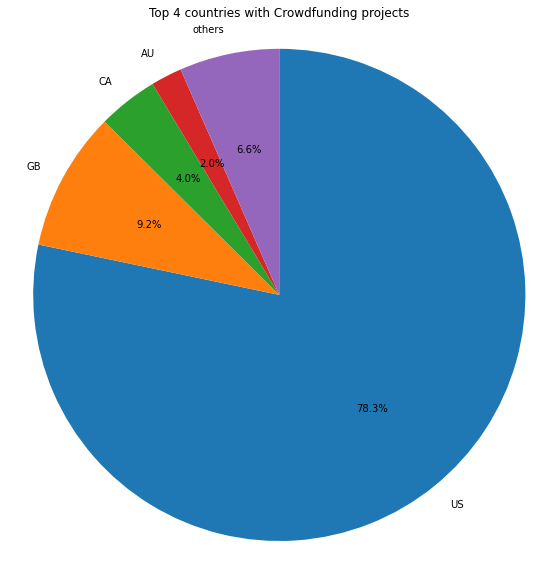

In [23]:
#The percentage distribution of the top 4 countries
plt.figure(figsize = [10, 10])

df = pd.DataFrame(
    data = {'country': kickstarter['country'].value_counts().index, 'value' :kickstarter['country'].value_counts()},
    ).sort_values('value', ascending = False)
#the top 4
df1 = df[:4].copy()

#others
new_row = pd.DataFrame(data = {
    'country' : ['others'],
    'value' : [df['value'][4:].sum()]
})

#combining top 4 with others
df2 = pd.concat([df1, new_row])


#plt.pie(df2, y = 'value', labels = df2['country'], autopct='%1.1f%%')
plt.pie(df2['value'], labels = df2['country'], startangle = 90,
        counterclock = False, autopct='%1.1f%%');
plt.axis('square')
plt.title('Top 4 countries with Crowdfunding projects')
plt.show()

The above plot shows that US account for more than 78% of all kickstarter projects, followed by GB with 9% then Canada with 4%. While all other countries only have 7% of all kickstarter projects.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The visuals have shown that the majority of projects have failed or canceled (around 60%, and 10% repectively) while only 30% have succeeded.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> When investigating the distribution of the launch and deadline dates of kickstarter projects, they were not consistent where some observations launched at 1970 distorted the distribution of the launch date, so I filtered out observations with launch date before 2009. Additionally, I removed outliers from the dataset before moving forward.

## BIVARIATE
To start off with, I want to look at the pairwise correlations present between features in the data.

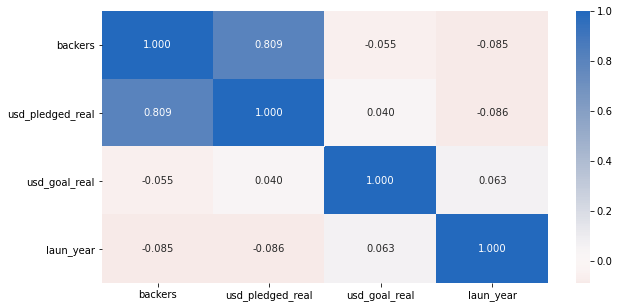

In [24]:
# correlation plot
plt.figure(figsize = [10, 5])
sb.heatmap(kickstarter.corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

It can be observed that there is a high positive correlation between the number of backers and the amount pledged to the kickstarter project. Additionally, there is a weak positive association between the goal amount set to the project and the duration between the launch and deadline of the kickstarter project. 

In [25]:
# creating a new feature for the duration set for the kickstarter project to raise the fund
kickstarter['duration'] = (kickstarter['deadline'] - kickstarter['launched']).dt.days
kickstarter['duration'] 

0         58
1         59
3         29
4         55
6         19
          ..
378655    44
378657    26
378658    45
378659    30
378660    27
Name: duration, Length: 277704, dtype: int64

In [26]:
numeric_vars = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']

<Figure size 1080x1080 with 0 Axes>

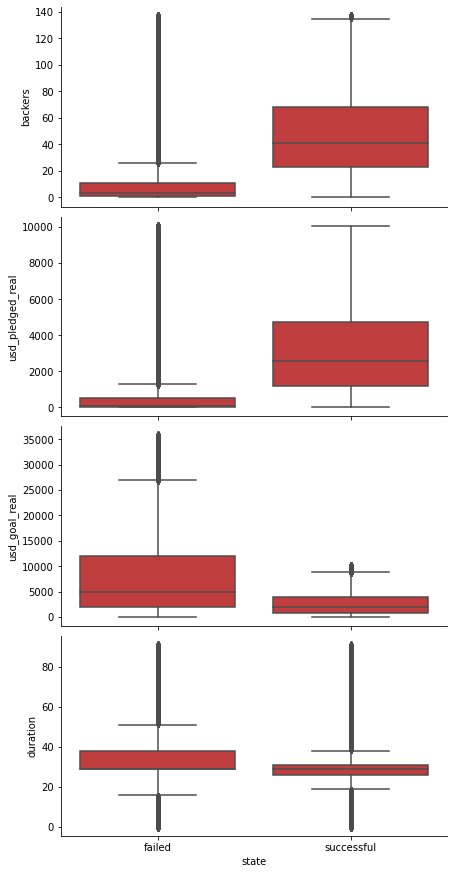

In [27]:
# the correlation between the numeric features and the state of the kickstarter projects
def boxgrid(x, y, **kwargs):
    default_color = sb.color_palette()[3]
    sb.boxplot(x, y, color = default_color);

plt.figure(figsize = [15, 15]);
g = sb.PairGrid(data = kickstarter, x_vars = ['state'], y_vars = numeric_vars,
                height = 3, aspect =2);
g.map(boxgrid);
plt.show();

The Boxplots above show the correlation between various numeric features and the state of the kickstarter project. The first and second plots shows that the median number of backers and the median pledged amount are higher for successful projects as compared to failed/canceled projects. The third and fourth plots show that the goal amount and duration are negatively correlated with project success. Next, we shall look at the correlation between state and categories.

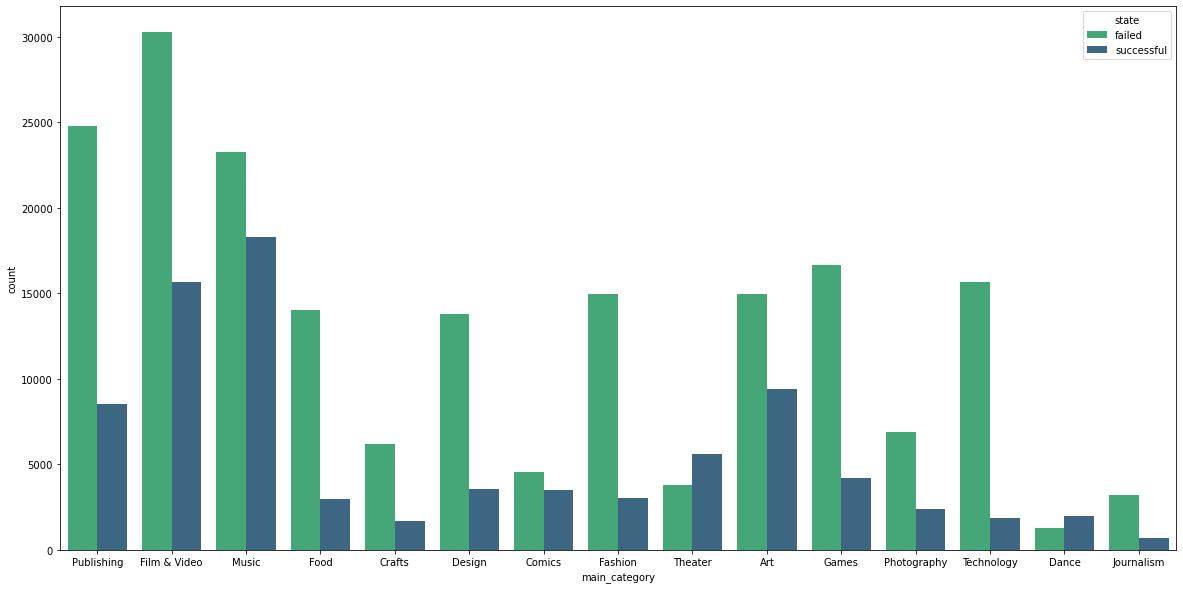

In [28]:
# the correlation between main_category and the state of the kickstarter projects
plt.figure(figsize = [20, 10])
sb.countplot(data = kickstarter, x = 'main_category', hue = 'state', palette = 'viridis_r')

The figure shows that the proportion of failed projects is higher than the successful projects in all categories except for the theater and the Dance categories.

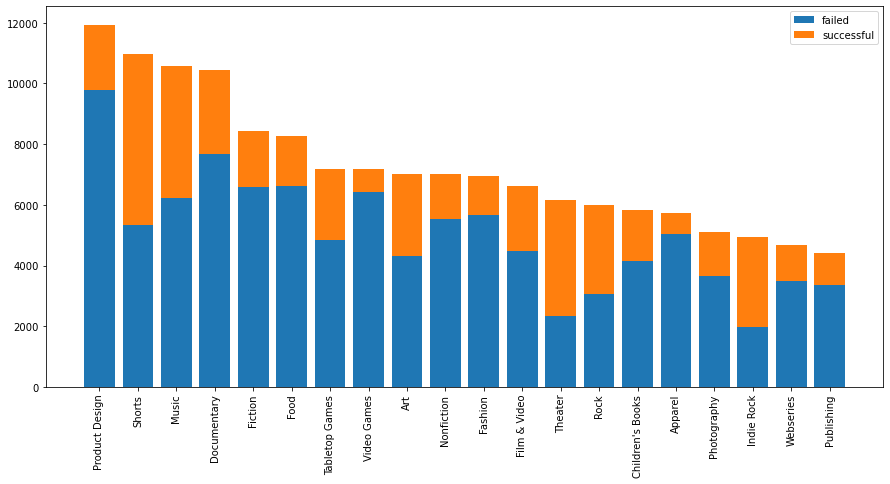

In [29]:
# The correlation between top 20 subcategories and the state of the kickstarter projects
plt.figure(figsize = [15, 7])
cat1_order = kickstarter['category'].value_counts().index[0:20]
cat2_order = kickstarter['state'].value_counts().index
baselines = np.zeros(len(cat1_order))
# for each second-variable category:
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = kickstarter[kickstarter['state'] == cat2]['category'].value_counts()
    # then plot those counts on top of the accumulated baseline
    plt.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines)
    baselines += inner_counts[cat1_order]

plt.xticks(np.arange(len(cat1_order)), cat1_order)
plt.legend(cat2_order)
plt.xticks(rotation=90)

plt.show()

The figure shows that the proportion of failed projects is higher than the successful projects in all top 20 sub-categories except for shorts, theater, Rock and Indi Rock. Next we will explore how the amount of pledge differs across categories. 

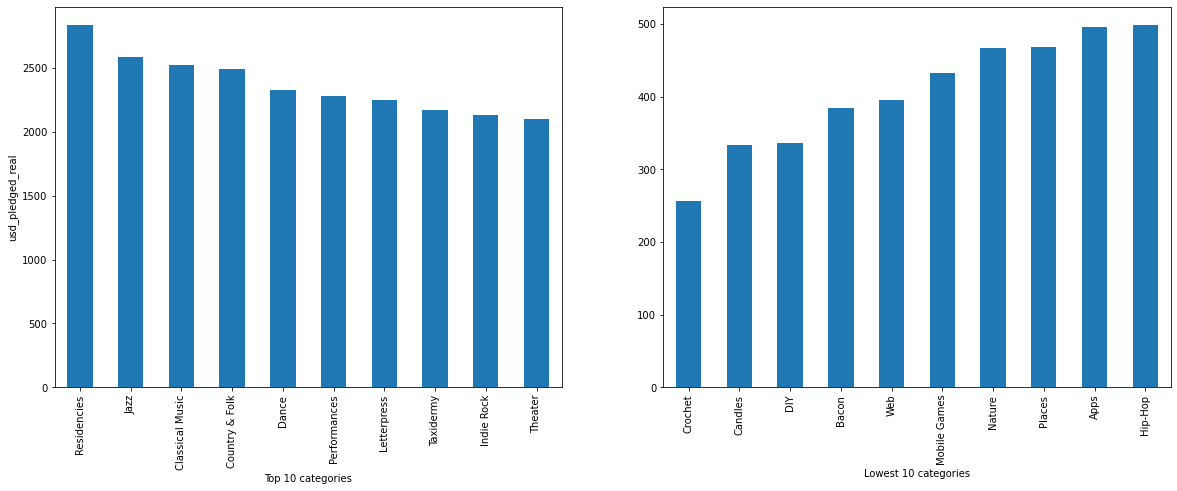

In [30]:
## The correlation between top and lowest subcategories and the  amount of pledge to kickstarter projects

plt.figure(figsize = [20, 7])
plt.subplot(1, 2, 1)
kickstarter.groupby(['category']).mean().sort_values("usd_pledged_real", ascending = False)[:10]['usd_pledged_real'].plot.bar();

plt.xlabel('Top 10 categories');
plt.ylabel('usd_pledged_real');

plt.subplot(1, 2, 2)
kickstarter.groupby(['category']).mean().sort_values("usd_pledged_real", ascending = True)[:10]['usd_pledged_real'].plot.bar();
plt.xlabel('Lowest 10 categories');
#plt.ylabel('usd_pledged_real');

The first plot shows that the Residences, Jazz and classical music obtain the highest pledge across subcategories. However, the second plot shows that Crochet and Candies obtain the lowest pledge.

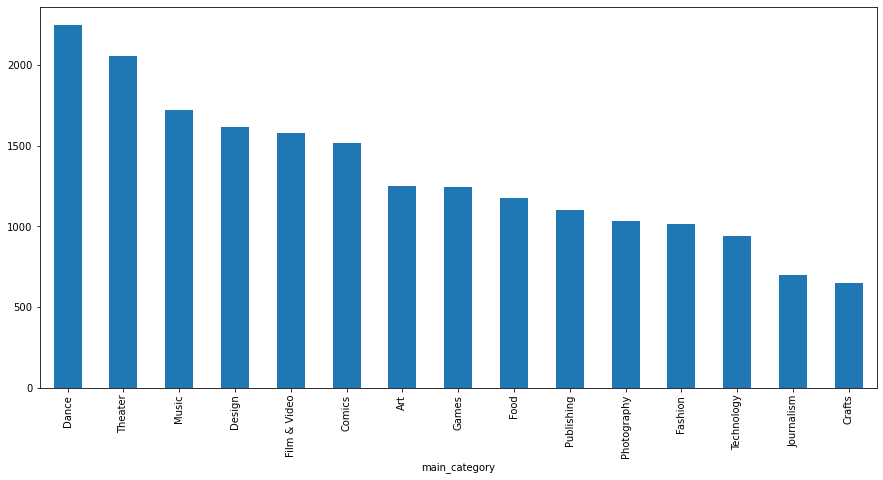

In [31]:
## The correlation between main categories and the  amount of pledge to kickstarter projects
plt.figure(figsize = [15, 7])
kickstarter.groupby(['main_category']).mean().sort_values("usd_pledged_real", ascending = False)['usd_pledged_real'].plot.bar();

The figure shows that the Dance, Theater and Music obtain the highest pledge across main categories.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Firstly, the success of the project is positively correlated with the number of backers and the amount of pledge, however, it is negatively associated with the goal amount and the duration from the launch date to deadline. Secondly, the project success is more likely in the music and film & video categories.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

>  Dance, Theater and Music obtain the highest pledge amount across main categories while Residences, Jazz and classical music obtain the highest pledge across subcategories.

## MULTIVARIATE

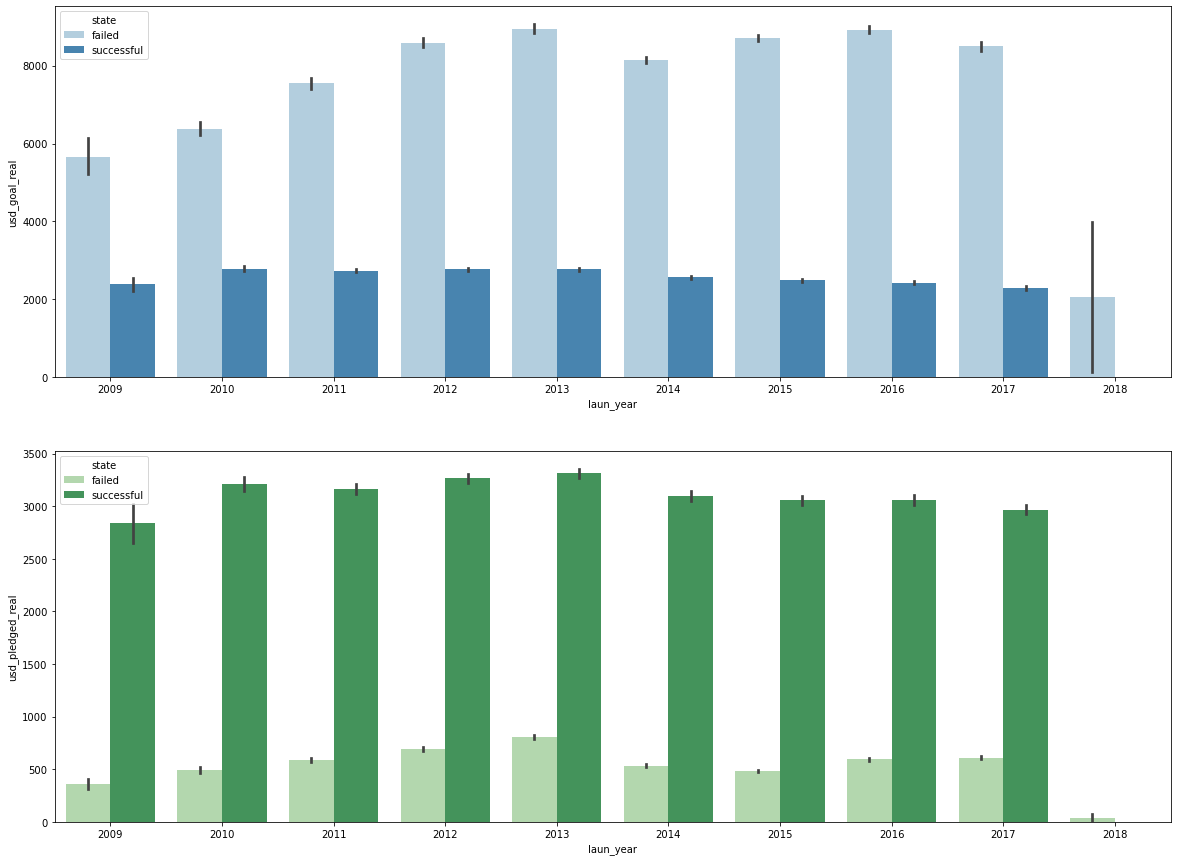

In [32]:
# How the goal amount and the pledge amount differs between failed and successful groups across years  
plt.figure(figsize = [20, 15])
plt.subplot(2, 1, 1)
sb.barplot(data = kickstarter, x = 'laun_year', y = 'usd_goal_real', hue = 'state', palette = 'Blues');

plt.subplot(2, 1, 2)
sb.barplot(data = kickstarter, x = 'laun_year', y = 'usd_pledged_real', hue = 'state', palette = 'Greens');

The first plot shows that the goal amount for the failed projects is always higher than that for the successful projects multiple times across years. Interestingly, the goal amount for succussful projects did not change significantly across years. As expected, the second plot shows that the pledge amount for failed projects is consistently lower than that of successful projects across years. Similarly, the pledge amount for successful projects did not change significantly across years. Overall, the figure shows that the kickstarters are too optimisitic when determining the goal amount which is relatively in a higher range than the actual pledged amount. 

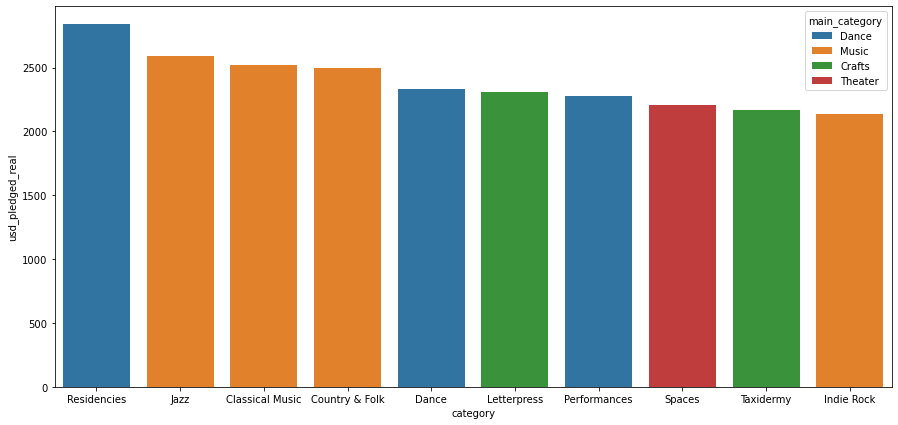

In [33]:
# The pledge amount raised by top 10 sub-categories and their respective categories
sub_cat = kickstarter.groupby(['category','main_category']).mean().sort_values("usd_pledged_real", ascending = False)[:10]
sub_cat.reset_index(inplace=True)

plt.figure(figsize = [15, 7])
sb.barplot(data = sub_cat, x = 'category', y = 'usd_pledged_real', hue = 'main_category', dodge = False);


The highest pledge amount raised by residencies in the Dance category which raised more than 2700 USD followed by Jazz in the music category which raised around 2500 USD. Four out of the top 10 fund raising categories fall in the Music class (bars in Orange) and three of them fall in the Dance class (bars in blue).

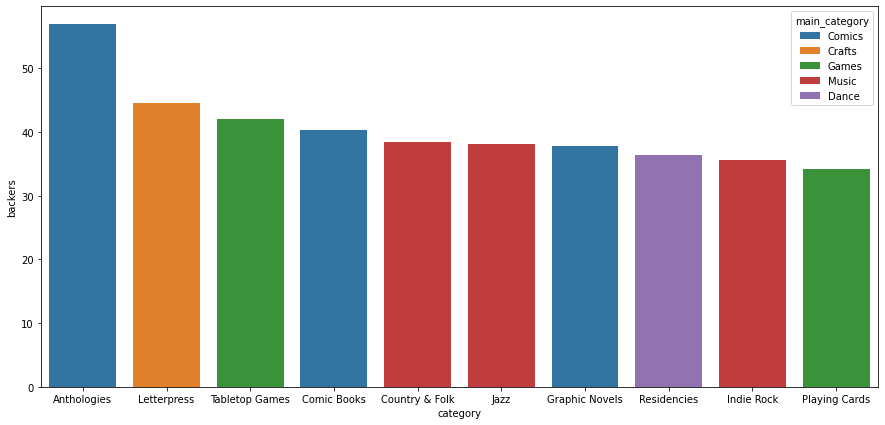

In [34]:
# The number of backers of top 10 sub-categories and their respective categories
sub_cat2 = kickstarter.groupby(['category','main_category']).mean().sort_values("backers", ascending = False)[:10]
sub_cat2.reset_index(inplace=True)
plt.figure(figsize = [15, 7])
sb.barplot(data = sub_cat2, x = 'category', y = 'backers', hue = 'main_category', dodge = False);

The highest number of backers exist in Anthologies in the Comics class followed by Letterpress in Crafts class. Three out of the top 10 backed categories fall in the Comic class (bars in Blue) and three of them fall in the Music class (bars in Red).

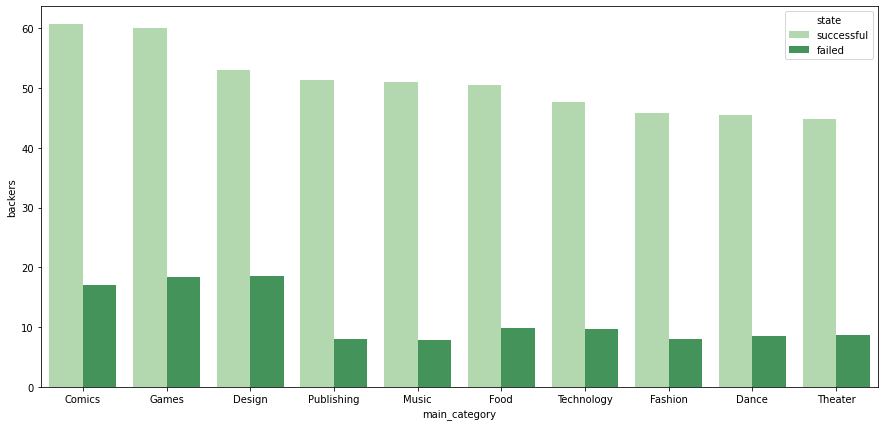

In [38]:
# the number of backers in each main category for successful and failed projects
sub_cat3 = kickstarter.groupby(['main_category', 'state']).mean().sort_values("backers", ascending = False)
sub_cat3.reset_index(inplace=True)
plt.figure(figsize = [15, 7])
sb.barplot(data = sub_cat3, x = 'main_category', y = 'backers', hue = 'state', palette = 'Greens');
plt.xlim(-0.5,9.5);

The figure shows that the highest number of backers fall in the Comics and Games classes. Consistently, the number of backers is consistently higher in the successful projects compared to failed projects.

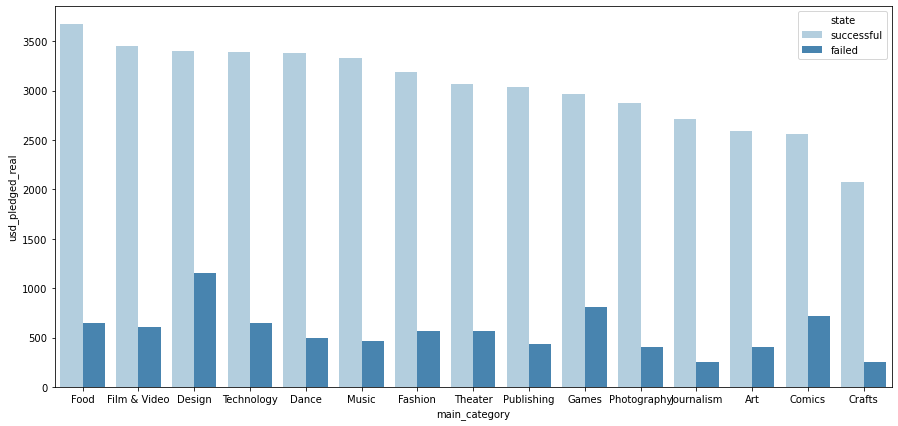

In [36]:
# The amount of Fundraising by main categories for succussful and failed projects
sub_cat4 = kickstarter.groupby(['state','main_category']).mean().sort_values("usd_pledged_real", ascending = False)
sub_cat4.reset_index(inplace=True)

plt.figure(figsize = [15, 7])
sb.barplot(data = sub_cat4, x = 'main_category', y = 'usd_pledged_real', hue = 'state', palette = 'Blues');
#plt.xlim(-0.5, 4.5)

The figure shows that the top fundraising project categories are Food, Film & Video and design. While the successful projects in these categories raise around 3500 USD, failed projects raise only 500-1000 USD.

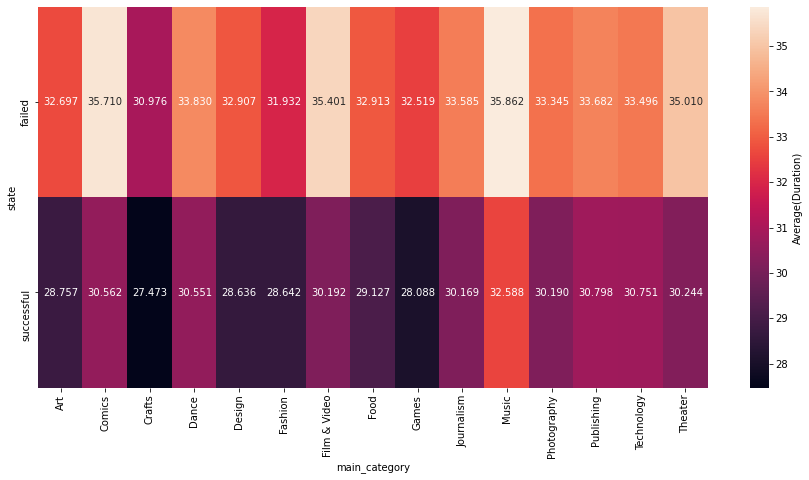

In [37]:
# The average duration of fundraising of successful and failed projects across categories
plt.figure(figsize = [15, 7])
cat_means = kickstarter.groupby(['main_category', 'state']).mean()['duration']
cat_means = cat_means.reset_index(name = 'duration_avg')
cat_means = cat_means.pivot(index = 'state', columns = 'main_category',
                            values = 'duration_avg')
sb.heatmap(cat_means, annot = True, fmt = '.3f',
           cbar_kws = {'label' : 'Average(Duration)'});

The figure shows that the average duration of fundraising ranages from 27 to 35.7 days. Successful projects tend to take shorter duration where crafts category has the lowest average duration of 27 days and music catgory has the highest average duration of 32.5 days. Failed projects tend to take longer duration where Dance class takes the lowest average duration of 30.9 days and Music class takes the longest average duration of 35.8 days.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> The analysis reveals that the kickstarters are too optimisitic when determining the goal amount which is relatively in a higher range than the actual pledged amount. The top fundraising projects falls mainly in the Music and Dance categories. Successful projects tend to take shorter fundraising duration while Failed projects tend to take longer duration. The number of backers is consistently higher in the successful projects compared to failed projects.

### Were there any interesting or surprising interactions between features?

> Surprisingly, the goal amount is negatively associated with success over years indicating that setting higher goals is a detriment for project success. Interestingly, the goal amount and the pledge amount for succussful projects did not change significantly across years indicating that the kickstarter projects did not gain more popularity overtime.